# **Chargement des librairies**

In [1]:
# Système
import os
import re
from joblib import dump

# Données
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Progression
from tqdm import tqdm

# Transformers
from transformers import CamembertForSequenceClassification, Trainer
from datasets import load_from_disk

# PyTorch & Vision
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.functional import softmax

# Image
from PIL import Image

# Scikit-learn : modèles et métriques
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix

# XGBoost
import xgboost as xgb


In [2]:
labelcat = {
    10 : "Livre occasion",
    40 : "Jeu vidéo, accessoire tech.",
    50 : "Accessoire Console",
    60 : "Console de jeu",
    1140 : "Figurine",
    1160 : "Carte Collection",
    1180 : "Jeu Plateau",
    1280 : "Jouet enfant, déguisement",
    1281 : "Jeu de société",
    1300 : "Jouet tech",
    1301 : "Paire de chaussettes",
    1302 : "Jeu extérieur, vêtement",
    1320 : "Autour du bébé",
    1560 : "Mobilier intérieur",
    1920 : "Chambre",
    1940 : "Cuisine",
    2060 : "Décoration intérieure",
    2220 : "Animal",
    2280 : "Revues et journaux",
    2403 : "Magazines, livres et BDs",
    2462 : "Jeu occasion",
    2522 : "Bureautique et papeterie",
    2582 : "Mobilier extérieur",
    2583 : "Autour de la piscine",
    2585 : "Bricolage",
    2705 : "Livre neuf",
    2905 : "Jeu PC",
}

# **Generation probabilites**

## Probabilite textuelles

In [18]:
# Chargement du meilleur modèle CamemBERT entraîné
model_path = "./Camembert/camembert_modele_1" 
model = CamembertForSequenceClassification.from_pretrained(model_path)

save_path = "./L_fusion/proba/"
os.makedirs(save_path, exist_ok=True) 

# Chargement du Trainer
trainer = Trainer(model=model)

# Fonction pour récupérer les probabilités et toutes les infos (productid, prdtypecode, label)
def get_predictions(dataset, dataset_name):
    print(f"\n Génération des probabilités pour {dataset_name}...")

    # Récupérer les prédictions
    predictions = trainer.predict(dataset)
    logits = torch.tensor(predictions.predictions)  # Convertir en tensor PyTorch

    # Appliquer Softmax pour obtenir les probabilités
    probabilities = softmax(logits, dim=1).numpy()

    # Récupérer `productid`, `prdtypecode` et `label`
    product_ids = dataset["productid"]
    prdtypecodes = dataset["prdtypecode"]
    labels = dataset["label"]  # Ajout du label réel

    # Creation d'un DataFrame avec les résultats
    df = pd.DataFrame({
        "productid": product_ids,
        "prdtypecode": prdtypecodes,
        "label": labels,  # Label réel
        "predicted_class": np.argmax(probabilities, axis=1),  # Classe prédite
        "probabilities": probabilities.tolist()  # Liste des probabilités par classe
    })

    # Sauvegarde en CSV
    csv_path = os.path.join(save_path, f"probabilities_{dataset_name}.csv")
    df.to_csv(csv_path, index=False)
    print(f" Résultats enregistrés dans {csv_path}")

    return df

#  Exécution sur les datasets tokenisés
P_texte_train = get_predictions(train_dataset, "train")
P_texte_val = get_predictions(val_dataset, "val")
P_texte_test = get_predictions(test_dataset, "test")



 Génération des probabilités pour train...


 Résultats enregistrés dans ./L_fusion/proba/probabilities_train.csv

 Génération des probabilités pour val...


 Résultats enregistrés dans ./L_fusion/proba/probabilities_val.csv

 Génération des probabilités pour test...


 Résultats enregistrés dans ./L_fusion/proba/probabilities_test.csv


## Probabilites images

### Images du train

In [3]:
# Définition des chemins
model_path = "./RESNET50/resnet50_best_20250320_033450.pth"
image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\train"

# Chargement du modèle PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 27) 
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Transformations des images 
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Liste pour stocker les résultats
results = []
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Prédiction avec suivi en temps réel
print(f" Début des prédictions sur {len(image_files)} images...")

for filename in tqdm(image_files, desc="Prédiction des images"):
    image_path = os.path.join(image_folder, filename)

    # Chargement et transformation image
    try:
        img = Image.open(image_path).convert("RGB")
        img = transform(img)
        img = img.unsqueeze(0).to(device)
    except Exception as e:
        print(f" Erreur chargement {filename} : {e}")
        continue

    # Prédiction
    try:
        with torch.no_grad():
            output = model(img)
            probabilities = softmax(output, dim=1).cpu().numpy()[0]
            top3_indices = np.argsort(probabilities)[-3:][::-1]  
            predicted_class = top3_indices[0]  # Classe la plus probable
    except Exception as e:
        print(f" Erreur prédiction {filename} : {e}")
        continue

    # Ajout des résultats
    results.append({
        "image": filename,
        "predicted_class": predicted_class,
        "top3_classes": top3_indices.tolist(),  
        "probabilities": probabilities.tolist()
    })

# Sauvegarde des résultats dans un CSV
csv_path = "./L_fusion/proba/probabilities_images_train_raw.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

try:
    P_images_train = pd.DataFrame(results)
    P_images_train.to_csv(csv_path, index=False)
    print(f" Prédictions terminées ! Résultats enregistrés dans : {csv_path}")
except Exception as e:
    print(f" Erreur enregistrement CSV : {e}")


 Début des prédictions sur 67932 images...


Prédiction des images: 100%|██████████| 67932/67932 [12:42<00:00, 89.09it/s] 


 Prédictions terminées ! Résultats enregistrés dans : ./L_fusion/proba/probabilities_images_train_raw.csv


### Images du val

In [4]:
# Définition des chemins
model_path = "./RESNET50/resnet50_best_20250320_033450.pth"
image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\val"

# Chargement du modèle PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 27)  
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Transformations des images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Liste pour stocker les résultats
results = []
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Prédiction avec suivi en temps réel 
print(f" Début des prédictions sur {len(image_files)} images...")

for filename in tqdm(image_files, desc="Prédiction des images"):
    image_path = os.path.join(image_folder, filename)

    # Chargement et transformation des images
    try:
        img = Image.open(image_path).convert("RGB")
        img = transform(img)
        img = img.unsqueeze(0).to(device)
    except Exception as e:
        print(f" Erreur chargement {filename} : {e}")
        continue

    # Prédiction
    try:
        with torch.no_grad():
            output = model(img)
            probabilities = softmax(output, dim=1).cpu().numpy()[0]
            top3_indices = np.argsort(probabilities)[-3:][::-1]  
            predicted_class = top3_indices[0]  # Classe la plus probable
    except Exception as e:
        print(f" Erreur prédiction {filename} : {e}")
        continue

    # Ajout des résultats
    results.append({
        "image": filename,
        "predicted_class": predicted_class,
        "top3_classes": top3_indices.tolist(), 
        "probabilities": probabilities.tolist()
    })

# Sauvegarde des résultats dans un CSV
csv_path = "./L_fusion/proba/probabilities_images_val_raw.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

try:
    P_val_train = pd.DataFrame(results)
    P_val_train.to_csv(csv_path, index=False)
    print(f" Prédictions terminées ! Résultats enregistrés dans : {csv_path}")
except Exception as e:
    print(f" Erreur enregistrement CSV : {e}")


 Début des prédictions sur 8492 images...


Prédiction des images: 100%|██████████| 8492/8492 [01:36<00:00, 88.09it/s] 


 Prédictions terminées ! Résultats enregistrés dans : ./L_fusion/proba/probabilities_images_val_raw.csv


### Images du test

In [22]:
# Définition des chemins 
model_path = "./RESNET50/resnet50_best_20250320_033450.pth"
image_folder = r"C:\Users\rudy_\Documents\Datascientest\Projet Rakuten\images\images\test"


#  Chargement du modèle PyTorch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, 27)  
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Transformations des images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Liste pour stocker les résultats 
results = []
image_files = [f for f in os.listdir(image_folder) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

# Prédiction avec suivi en temps réel 
print(f" Début des prédictions sur {len(image_files)} images...")

for filename in tqdm(image_files, desc="Prédiction des images"):
    image_path = os.path.join(image_folder, filename)

    # Chargement et transformation des images 
    try:
        img = Image.open(image_path).convert("RGB")
        img = transform(img)
        img = img.unsqueeze(0).to(device)
    except Exception as e:
        print(f" Erreur chargement {filename} : {e}")
        continue

    # Prédiction 
    try:
        with torch.no_grad():
            output = model(img)
            probabilities = softmax(output, dim=1).cpu().numpy()[0]
            top3_indices = np.argsort(probabilities)[-3:][::-1]  
            predicted_class = top3_indices[0]  # Classe la plus probable
    except Exception as e:
        print(f" Erreur prédiction {filename} : {e}")
        continue

    # Ajout des résultats
    results.append({
        "image": filename,
        "predicted_class": predicted_class,
        "top3_classes": top3_indices.tolist(),  
        "probabilities": probabilities.tolist()
    })

# Sauvegarde des résultats dans un CSV 
csv_path = "./L_fusion/proba/probabilities_images_test_raw.csv"
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

try:
    P_val_train = pd.DataFrame(results)
    P_val_train.to_csv(csv_path, index=False)
    print(f" Prédictions terminées ! Résultats enregistrés dans : {csv_path}")
except Exception as e:
    print(f" Erreur enregistrement CSV : {e}")


 Début des prédictions sur 8492 images...


Prédiction des images: 100%|██████████| 8492/8492 [01:38<00:00, 85.80it/s] 


 Prédictions terminées ! Résultats enregistrés dans : ./L_fusion/proba/probabilities_images_test_raw.csv


# **Chargement Probabilites**

## Probabilites textes

In [3]:
# Chargement des fichiers
P_texte_train = pd.read_csv("./L_fusion/proba/probabilities_train.csv")  
P_texte_val = pd.read_csv("./L_fusion/proba/probabilities_val.csv")  
P_texte_test = pd.read_csv("./L_fusion/proba/probabilities_test.csv")

# Vérification que les fichiers sont bien chargés
print("DataFrames chargés avec succès !")
print(f"Train : {P_texte_train.shape[0]} lignes, {P_texte_train.shape[1]} colonnes")
print(f"Validation : {P_texte_val.shape[0]} lignes, {P_texte_val.shape[1]} colonnes")
print(f"Test : {P_texte_test.shape[0]} lignes, {P_texte_test.shape[1]} colonnes")


DataFrames chargés avec succès !
Train : 66933 lignes, 5 colonnes
Validation : 8467 lignes, 5 colonnes
Test : 8456 lignes, 5 colonnes


## Probabilites images

In [4]:
# Chargement des fichiers
train_csv_path  = "./L_fusion/proba/probabilities_images_train_raw.csv"
val_csv_path  = "./L_fusion/proba/probabilities_images_val_raw.csv"
test_csv_path  = "./L_fusion/proba/probabilities_images_test_raw.csv"

P_images_train = pd.read_csv(train_csv_path)
P_images_val = pd.read_csv(val_csv_path)
P_images_test = pd.read_csv(test_csv_path)

# Vérification que les fichiers sont bien chargés
print(" Fichier chargé avec succès !")
print(f"Nombre de lignes : {P_images_train.shape[0]}, Nombre de colonnes : {P_images_train.shape[1]}")
print(f"Nombre de lignes : {P_images_val.shape[0]}, Nombre de colonnes : {P_images_val.shape[1]}")
print(f"Nombre de lignes : {P_images_test.shape[0]}, Nombre de colonnes : {P_images_test.shape[1]}")

# Affichage premières lignes pour inspection
display (P_images_train.head())
display (P_images_val.head())
display (P_images_test.head())

 Fichier chargé avec succès !
Nombre de lignes : 67932, Nombre de colonnes : 4
Nombre de lignes : 8492, Nombre de colonnes : 4
Nombre de lignes : 8492, Nombre de colonnes : 4


,image,predicted_class,top3_classes,probabilities
0,image_1000076039_product_580161.jpg,19,"[19, 0, 18]","[0.4661746621131897, 0.0004087558772880584, 6...."
1,image_1000095646_product_344209267.jpg,5,"[5, 7, 1]","[0.00016330042853951454, 0.001121808192692697,..."
2,image_1000099971_product_352683003.jpg,0,"[0, 19, 25]","[0.77837735414505, 0.0008072209893725812, 0.00..."
3,image_1000100220_product_352601770.jpg,19,"[19, 0, 8]","[0.031000511720776558, 6.191105967445765e-06, ..."
4,image_1000222973_product_351172420.jpg,1,"[1, 8, 7]","[0.04130406305193901, 0.19938069581985474, 0.0..."


,image,predicted_class,top3_classes,probabilities
0,image_1000089455_product_348990858.jpg,18,"[18, 0, 19]","[0.16720539331436157, 0.00023030977172311395, ..."
1,image_1000092894_product_353108104.jpg,19,"[19, 20, 16]","[0.006437425501644611, 0.012398057617247105, 0..."
2,image_1000093804_product_343306951.jpg,5,"[5, 0, 8]","[0.0006115756696090102, 0.00013997744827065617..."
3,image_1000095647_product_148177050.jpg,10,"[10, 8, 11]","[0.002876748563721776, 0.01154601201415062, 0...."
4,image_1000425043_product_349046352.jpg,7,"[7, 4, 12]","[2.571721893218637e-07, 1.7439758721593535e-06..."


,image,predicted_class,top3_classes,probabilities
0,image_1000441257_product_356912201.jpg,19,"[19, 0, 18]","[0.39323028922080994, 7.388630365312565e-06, 9..."
1,image_1000523845_product_357696021.jpg,23,"[23, 22, 21]","[0.0004023974761366844, 0.0009950746316462755,..."
2,image_1000855430_product_361327550.jpg,19,"[19, 18, 0]","[0.004742591176182032, 5.0311638915445656e-05,..."
3,image_1001631392_product_302693296.jpg,22,"[22, 16, 23]","[8.880487030182849e-07, 0.0001932514423970133,..."
4,image_1001646826_product_371862664.jpg,22,"[22, 12, 13]","[0.000126089493278414, 0.00032071940950118005,..."


In [5]:
def extract_product_id(filename):
    match = re.search(r"product_(\d+)", filename)  # Recherche du pattern "product_XXXX"
    return int(match.group(1)) if match else None

# Appliquer de la fonction de transformation sur les DataFrames
P_images_train["productid"] = P_images_train["image"].apply(extract_product_id)
P_images_val["productid"] = P_images_val["image"].apply(extract_product_id)
P_images_test["productid"] = P_images_test["image"].apply(extract_product_id)

# Verification des résultats
display(P_images_train.head())
display(P_images_val.head())
display(P_images_test.head())

,image,predicted_class,top3_classes,probabilities,productid
0,image_1000076039_product_580161.jpg,19,"[19, 0, 18]","[0.4661746621131897, 0.0004087558772880584, 6....",580161
1,image_1000095646_product_344209267.jpg,5,"[5, 7, 1]","[0.00016330042853951454, 0.001121808192692697,...",344209267
2,image_1000099971_product_352683003.jpg,0,"[0, 19, 25]","[0.77837735414505, 0.0008072209893725812, 0.00...",352683003
3,image_1000100220_product_352601770.jpg,19,"[19, 0, 8]","[0.031000511720776558, 6.191105967445765e-06, ...",352601770
4,image_1000222973_product_351172420.jpg,1,"[1, 8, 7]","[0.04130406305193901, 0.19938069581985474, 0.0...",351172420


,image,predicted_class,top3_classes,probabilities,productid
0,image_1000089455_product_348990858.jpg,18,"[18, 0, 19]","[0.16720539331436157, 0.00023030977172311395, ...",348990858
1,image_1000092894_product_353108104.jpg,19,"[19, 20, 16]","[0.006437425501644611, 0.012398057617247105, 0...",353108104
2,image_1000093804_product_343306951.jpg,5,"[5, 0, 8]","[0.0006115756696090102, 0.00013997744827065617...",343306951
3,image_1000095647_product_148177050.jpg,10,"[10, 8, 11]","[0.002876748563721776, 0.01154601201415062, 0....",148177050
4,image_1000425043_product_349046352.jpg,7,"[7, 4, 12]","[2.571721893218637e-07, 1.7439758721593535e-06...",349046352


,image,predicted_class,top3_classes,probabilities,productid
0,image_1000441257_product_356912201.jpg,19,"[19, 0, 18]","[0.39323028922080994, 7.388630365312565e-06, 9...",356912201
1,image_1000523845_product_357696021.jpg,23,"[23, 22, 21]","[0.0004023974761366844, 0.0009950746316462755,...",357696021
2,image_1000855430_product_361327550.jpg,19,"[19, 18, 0]","[0.004742591176182032, 5.0311638915445656e-05,...",361327550
3,image_1001631392_product_302693296.jpg,22,"[22, 16, 23]","[8.880487030182849e-07, 0.0001932514423970133,...",302693296
4,image_1001646826_product_371862664.jpg,22,"[22, 12, 13]","[0.000126089493278414, 0.00032071940950118005,...",371862664


## Fusion dataframes

In [6]:
# Fusion sur `productid`
df_merged_train = pd.merge(P_texte_train, P_images_train, on="productid", suffixes=("_text", "_image" ))
df_merged_val = pd.merge(P_texte_val, P_images_val, on="productid", suffixes=("_text", "_image" ))
df_merged_test = pd.merge(P_texte_test, P_images_test, on="productid", suffixes=("_text", "_image" ))

display (df_merged_train.tail())
display (df_merged_val.tail())
display (df_merged_test.tail())

,productid,prdtypecode,label,predicted_class_text,probabilities_text,image,predicted_class_image,top3_classes,probabilities_image
66928,168344610,2583,23,23,"[2.1190495317569003e-05, 4.012264525954379e-06...",image_921250362_product_168344610.jpg,23,"[23, 2, 1]","[1.2655857062782161e-05, 0.012937000952661037,..."
66929,168344611,2583,23,23,"[2.249794670206029e-05, 4.310741132940166e-06,...",image_921250231_product_168344611.jpg,23,"[23, 2, 1]","[1.2655857062782161e-05, 0.012937000952661037,..."
66930,168344612,2583,23,23,"[1.910162427520845e-05, 3.6628907764679752e-06...",image_921250046_product_168344612.jpg,23,"[23, 2, 1]","[1.2655857062782161e-05, 0.012937000952661037,..."
66931,92833916,10,0,0,"[0.9821927547454834, 0.0005054182838648558, 4....",image_907546731_product_92833916.jpg,25,"[25, 0, 19]","[0.20776677131652832, 7.240431614263798e-07, 1..."
66932,1696348280,2403,19,19,"[0.0017070375615730882, 4.1314899135613814e-05...",image_1098789272_product_1696348280.jpg,19,"[19, 0, 23]","[0.21146270632743835, 0.000691343389917165, 0...."


,productid,prdtypecode,label,predicted_class_text,probabilities_text,image,predicted_class_image,top3_classes,probabilities_image
8462,1082596891,10,0,0,"[0.5753338932991028, 0.0002897988597396761, 8....",image_1057867660_product_1082596891.jpg,0,"[0, 19, 25]","[0.5800203084945679, 0.001229616580531001, 3.1..."
8463,3957786314,2060,16,22,"[0.00022384336625691503, 3.1469644454773515e-0...",image_1269392308_product_3957786314.jpg,22,"[22, 23, 13]","[8.46508646645816e-06, 0.01855759508907795, 0...."
8464,1789637308,2522,21,21,"[5.495082223205827e-05, 1.5249916032189503e-06...",image_1102077692_product_1789637308.jpg,21,"[21, 8, 23]","[0.03085187077522278, 0.021235857158899307, 0...."
8465,4122557338,1300,9,9,"[5.7034743804251775e-05, 8.556630928069353e-05...",image_1294197029_product_4122557338.jpg,9,"[9, 7, 2]","[2.1216969153803333e-12, 2.2331082618620712e-0..."
8466,4172824950,1300,9,9,"[5.882515324628912e-05, 0.00012303070980124176...",image_1307787540_product_4172824950.jpg,9,"[9, 13, 22]","[2.1010009731980972e-05, 0.010512808337807655,..."


,productid,prdtypecode,label,predicted_class_text,probabilities_text,image,predicted_class_image,top3_classes,probabilities_image
8451,4057772670,1560,13,13,"[4.687378350354265e-06, 1.2452469491108786e-06...",image_1283013073_product_4057772670.jpg,9,"[9, 21, 22]","[3.616874892031774e-05, 0.018455728888511658, ..."
8452,1843977785,2403,19,1,"[0.011422042734920979, 0.9154642820358276, 0.0...",image_1104836840_product_1843977785.jpg,19,"[19, 1, 0]","[0.16190718114376068, 0.1783532053232193, 0.01..."
8453,4122838067,1300,9,9,"[5.245751526672393e-05, 1.372890892525902e-05,...",image_1294533136_product_4122838067.jpg,9,"[9, 7, 11]","[5.9818699810421094e-05, 2.5793988243094645e-0..."
8454,450498957,50,2,2,"[9.935583875630982e-06, 0.0026072736363857985,...",image_1012502655_product_450498957.jpg,20,"[20, 19, 2]","[0.018012313172221184, 0.024956006556749344, 0..."
8455,3986443130,2220,17,17,"[0.00014856806956231594, 0.0001242165162693709...",image_1272165005_product_3986443130.jpg,17,"[17, 7, 12]","[2.5899331035361683e-07, 4.593303799538262e-07..."


In [7]:
# Enregistrer les DataFrames en CSV
df_merged_train.to_csv("./L_fusion/df/merged_train_raw.csv", index=False)
df_merged_val.to_csv("./L_fusion/df/merged_val_raw.csv", index=False)
df_merged_test.to_csv("./L_fusion/df/merged_test_raw.csv", index=False)

# **Chargement DF fusionnés**

In [5]:
# Chemins vers les fichiers
df_train_path = "./L_fusion/df/merged_train_raw.csv"
df_val_path = "./L_fusion/df/merged_val_raw.csv"
df_test_path = "./L_fusion/df/merged_test_raw.csv"

# Chargement des DataFrames
df_merged_train = pd.read_csv(df_train_path)
df_merged_val = pd.read_csv(df_val_path)
df_merged_test = pd.read_csv(df_test_path)

# **Max Rule**

La première approche testée est la Max Rule, où la classe retenue est celle ayant la probabilité la plus élevée entre les deux modèles. L’implémentation repose sur la conversion des probabilités des modèles texte et image en tableaux NumPy pour assurer leur compatibilité. Ensuite, chaque modèle prédit une classe via np.argmax(), qui sélectionne la classe ayant la probabilité la plus élevée. La fusion suit une règle simple : si les deux modèles prédisent la même classe, elle est conservée ; sinon, la classe avec la plus haute probabilité est retenue. Cette approche vise à exploiter la complémentarité des deux modèles en privilégiant les prédictions les plus confiantes


 Résultats avec la règle Maximale (Max Rule)
  - Weighted F1-score Train : 0.9478
  - Weighted F1-score Val   : 0.8899

 Rapport de classification (Max Rule) - TRAIN :
                             precision    recall  f1-score   support

             Livre occasion       0.90      0.90      0.90      2491
Jeu vidéo, accessoire tech.       0.93      0.94      0.93      1989
         Accessoire Console       0.94      0.95      0.95      1317
             Console de jeu       0.96      0.97      0.97       654
                   Figurine       0.85      0.95      0.90      2137
           Carte Collection       0.97      1.00      0.98      3161
                Jeu Plateau       0.88      0.62      0.72       611
  Jouet enfant, déguisement       0.93      0.83      0.88      3887
             Jeu de société       0.82      0.81      0.81      1636
                 Jouet tech       0.98      0.99      0.99      4010
       Paire de chaussettes       0.98      0.96      0.97       569
  

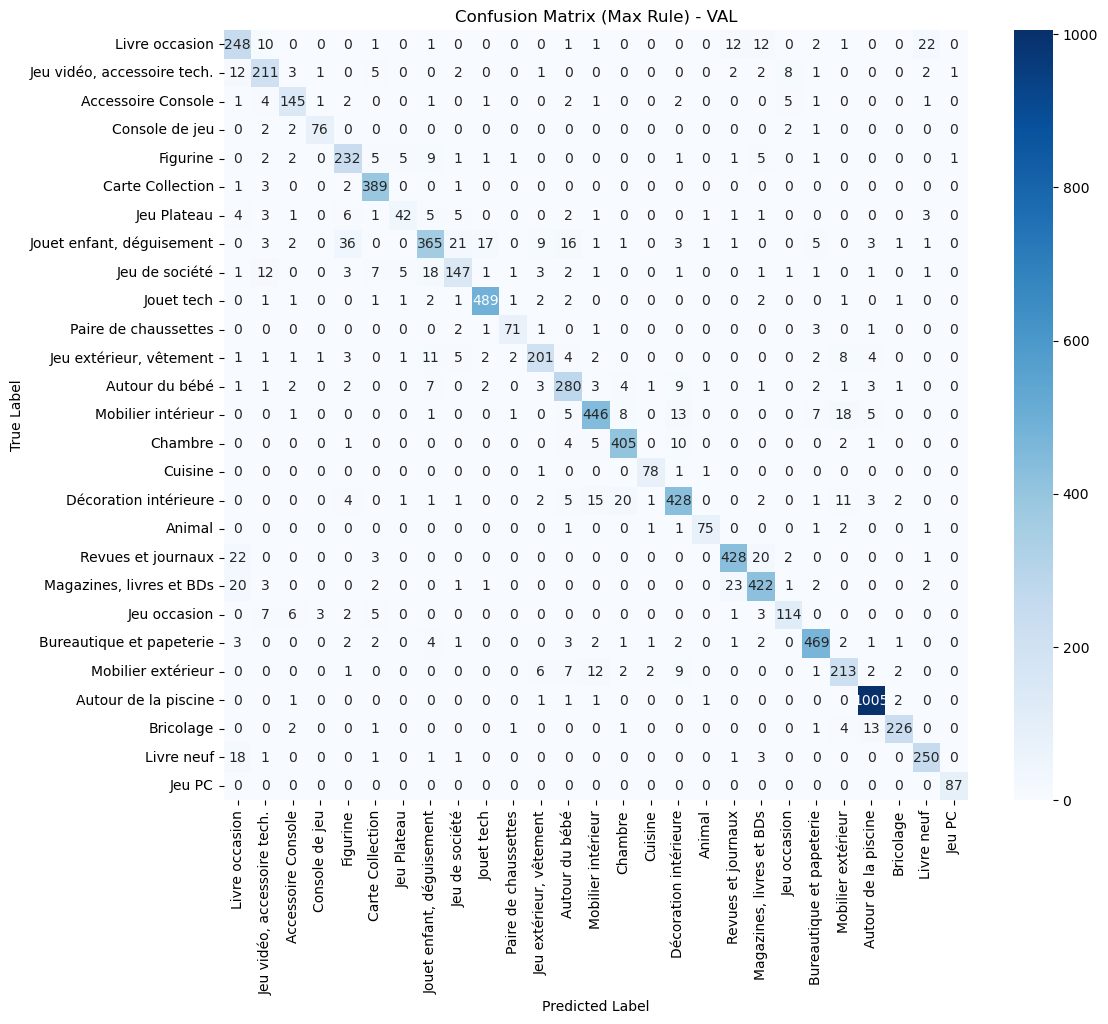

In [56]:
# Fonction de conversion des probabilités texte/image en tableau numpy
def safe_convert_probabilities(column):
    """Conversion sécurisée des chaînes de caractères en tableaux numpy"""
    return column.apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Extraction des classes prédites séparément pour les modèles texte et image (TRAIN)
y_pred_text_train = np.argmax(np.vstack(df_merged_train["probabilities_text"]), axis=1)
y_pred_image_train = np.argmax(np.vstack(df_merged_train["probabilities_image"]), axis=1)

# Extraction des classes prédites séparément pour les modèles texte et image (VALIDATION)
y_pred_text_val = np.argmax(np.vstack(df_merged_val["probabilities_text"]), axis=1)
y_pred_image_val = np.argmax(np.vstack(df_merged_val["probabilities_image"]), axis=1)

# Définition de la règle de fusion Max Rule (choix de la classe ayant la probabilité la plus forte entre texte et image)
def max_rule(pred_text, pred_image, prob_text, prob_image):
    """Application de la règle maximale sur les probabilités texte/image"""
    return np.where(
        pred_text == pred_image, pred_text,
        np.where(prob_text[np.arange(len(pred_text)), pred_text] >
                 prob_image[np.arange(len(pred_image)), pred_image],
                 pred_text, pred_image)
    )

# Calcul des prédictions fusionnées par la Max Rule (TRAIN)
y_pred_train_max = max_rule(
    y_pred_text_train, y_pred_image_train,
    np.vstack(df_merged_train["probabilities_text"]),
    np.vstack(df_merged_train["probabilities_image"])
)

# Calcul des prédictions fusionnées par la Max Rule (VALIDATION)
y_pred_val_max = max_rule(
    y_pred_text_val, y_pred_image_val,
    np.vstack(df_merged_val["probabilities_text"]),
    np.vstack(df_merged_val["probabilities_image"])
)

# Création du mapping entre index numériques (0 à 26) et labels réels (Rakuten)
sorted_labels = sorted(labelcat.keys())  # Liste triée des labels réels
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}  # Dictionnaire de correspondance index → label

# Conversion des labels réels dans les DataFrames d'entraînement et de validation
df_merged_train["label_real"] = df_merged_train["label"].map(index_to_label)
df_merged_val["label_real"] = df_merged_val["label"].map(index_to_label)

# Conversion des prédictions Max Rule (indices) en labels réels Rakuten
y_pred_train_max_real = np.array([index_to_label[idx] for idx in y_pred_train_max])
y_pred_val_max_real = np.array([index_to_label[idx] for idx in y_pred_val_max])

# Calcul du F1-score pondéré pour TRAIN et VALIDATION 
train_f1_max = f1_score(df_merged_train["label_real"], y_pred_train_max_real, average="weighted")
val_f1_max = f1_score(df_merged_val["label_real"], y_pred_val_max_real, average="weighted")

# Affichage des scores F1 pondérés
print(f"\n Résultats avec la règle Maximale (Max Rule)")
print(f"  - Weighted F1-score Train : {train_f1_max:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1_max:.4f}")

# Rapport de classification détaillé sur l'ensemble d'entraînement
print("\n Rapport de classification (Max Rule) - TRAIN :")
print(classification_report(
    df_merged_train["label_real"], 
    y_pred_train_max_real, 
    target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification détaillé sur l'ensemble de validation
print("\n Rapport de classification (Max Rule) - VAL :")
print(classification_report(
    df_merged_val["label_real"], 
    y_pred_val_max_real, 
    target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage de la matrice de confusion avec noms des catégories"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage graphique de la matrice de confusion sur VALIDATION 
plot_confusion_matrix(df_merged_val["label_real"], y_pred_val_max_real, sorted_labels, "Confusion Matrix (Max Rule) - VAL")


# **Soft Voting**

Second approche : Voting Classifier en mode Soft Voting pour fusionner les prédictions des modèles texte (CamemBERT) et image (ResNet). L'objectif est d'optimiser l'intégration des deux sources d'information afin d'améliorer la performance globale. L’hypothèse sous-jacente est que la fusion des probabilités issues des deux modèles permettrait de mieux exploiter leurs complémentarités et d'obtenir une classification plus robuste.



Lors de la combinaison des sorties du modele CamemBERT pour le texte et ResNet pour les images, à l’aide du VotingClassifier de scikit-learn, un problème technique se pose : ce classifieur attend impérativement une matrice de caractéristiques X et un vecteur cible y lors de l'entraînement, même si les prédictions sont basées uniquement sur des probabilités déjà calculées.

Or, dans notre cas, les modèles CamemBERT et ResNet produisent directement des probabilités, et il n’existe pas de matrice de caractéristiques d’entrée unique à fournir. Pour contourner cette contrainte, nous générons une matrice de "fake features" (X_train_fake, X_val_fake), généralement composée de zéros, de la forme (n_samples, 1).

Cette matrice factice ne contient aucune information utile pour la classification. Elle a uniquement pour but de satisfaire les exigences de l'interface du VotingClassifier. En pratique, le classifieur s’appuie uniquement sur les sorties probabilistes fournies par les modèles de base pour effectuer la prédiction finale.


 Résultats avec la règle Maximale (Soft Voting)
  - Weighted F1-score Train : 0.9538
  - Weighted F1-score Val   : 0.8939

 Évaluation du Voting Classifier sur l'ensemble d'entraînement :
                             precision    recall  f1-score   support

             Livre occasion       0.90      0.91      0.91      2491
Jeu vidéo, accessoire tech.       0.94      0.95      0.94      1989
         Accessoire Console       0.91      0.98      0.95      1317
             Console de jeu       0.99      0.94      0.96       654
                   Figurine       0.90      0.94      0.92      2137
           Carte Collection       0.99      0.99      0.99      3161
                Jeu Plateau       0.85      0.83      0.84       611
  Jouet enfant, déguisement       0.88      0.90      0.89      3887
             Jeu de société       0.91      0.76      0.83      1636
                 Jouet tech       0.99      0.99      0.99      4010
       Paire de chaussettes       0.99      0.98   

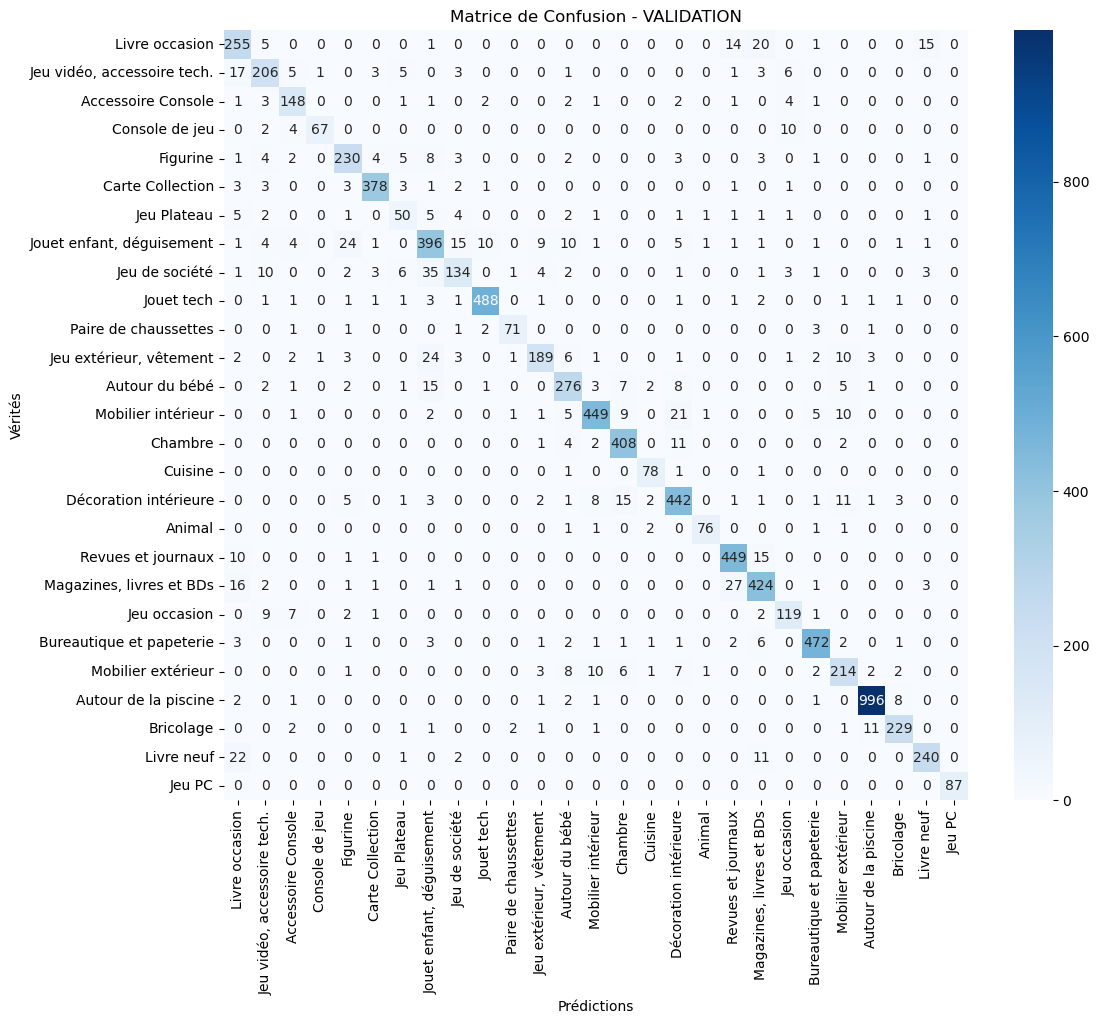


 VotingClassifier sauvegardé dans './L_fusion/Sauvegarde modeles/voting_classifier.joblib'


In [12]:
# Fonction de conversion des probabilités sous forme de chaînes vers des tableaux numpy
def safe_convert_probabilities(column):
    return column.apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

# Application de la conversion sur les colonnes de probabilités texte et image (pour TRAIN et VALIDATION)
for df in [df_merged_train, df_merged_val]:
    df[["probabilities_text", "probabilities_image"]] = df[
        ["probabilities_text", "probabilities_image"]
    ].apply(safe_convert_probabilities)

# Extraction des matrices de probabilités (Texte et Image) pour TRAIN et VALIDATION
P_texte_train, P_image_train = np.vstack(df_merged_train["probabilities_text"]), np.vstack(df_merged_train["probabilities_image"])
P_texte_val, P_image_val = np.vstack(df_merged_val["probabilities_text"]), np.vstack(df_merged_val["probabilities_image"])

# Vérification de la compatibilité dimensionnelle entre les matrices de probabilités
assert P_texte_train.shape == P_image_train.shape, "Les matrices TRAIN doivent avoir la même forme"
assert P_texte_val.shape == P_image_val.shape, "Les matrices VALIDATION doivent avoir la même forme"

# Construction du dictionnaire de correspondance entre index numériques et labels réels Rakuten
sorted_labels = sorted(labelcat.keys())  
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}  

# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Définition du wrapper CamemBERT compatible avec VotingClassifier 
class CamembertWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, P_train, P_val):
        self.P_train = P_train
        self.P_val = P_val
    
    def fit(self, X, y):
        pass  # Utilisation de probabilités pré-calculées (aucun entraînement requis)
    
    def predict_proba(self, X):
        return self.P_train if len(X) == len(self.P_train) else self.P_val
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Définition du wrapper ResNet compatible avec VotingClassifier 
class ResNetWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, P_train, P_val):
        self.P_train = P_train
        self.P_val = P_val
    
    def fit(self, X, y):
        pass  # Utilisation de probabilités pré-calculées (aucun entraînement requis)
    
    def predict_proba(self, X):
        return self.P_train if len(X) == len(self.P_train) else self.P_val
    
    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

# Instanciation des modèles de base à partir des probabilités texte et image
camembert_model = CamembertWrapper(P_texte_train, P_texte_val)
resnet_model = ResNetWrapper(P_image_train, P_image_val)

# Construction du VotingClassifier en mode soft voting avec pondération des modèles
voting_clf = VotingClassifier(
    estimators=[
        ('camembert', camembert_model),
        ('resnet', resnet_model)
    ],
    voting='soft',
    weights=[0.6, 0.4]  # Pondération des votes (60% texte, 40% image)
)

# Création des features factices pour respecter l'API de scikit-learn
X_train_fake = np.zeros((len(P_texte_train), 1))  
X_val_fake = np.zeros((len(P_texte_val), 1))  

# Entraînement fictif du VotingClassifier avec features factices
voting_clf.fit(X_train_fake, df_merged_train["label"])

# Génération des prédictions (indices) pour TRAIN et VALIDATION
y_pred_train = voting_clf.predict(X_train_fake)
y_pred_val = voting_clf.predict(X_val_fake)

# Ajout des labels réels dans les DataFrames d'entraînement et de validation
df_merged_train["label_real"] = df_merged_train["label"].map(index_to_label)
df_merged_val["label_real"] = df_merged_val["label"].map(index_to_label)

# Conversion des prédictions en labels réels Rakuten
y_pred_train_real = np.array([index_to_label[idx] for idx in y_pred_train])
y_pred_val_real = np.array([index_to_label[idx] for idx in y_pred_val])

# Calcul du F1-score pondéré pour l'ensemble d'entraînement et de validation
train_f1_max = f1_score(df_merged_train["label_real"], y_pred_train_real, average="weighted")
val_f1_max = f1_score(df_merged_val["label_real"], y_pred_val_real, average="weighted")

# Affichage des scores F1 pondérés
print(f"\n Résultats avec la règle Maximale (Soft Voting)")
print(f"  - Weighted F1-score Train : {train_f1_max:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1_max:.4f}")

# Évaluation du VotingClassifier : rapport de classification (TRAIN)
print("\n Évaluation du Voting Classifier sur l'ensemble d'entraînement :")
print(classification_report(df_merged_train["label_real"], y_pred_train_real, target_names=[labelcat[l] for l in sorted_labels]))
print(f" Accuracy sur train : {accuracy_score(df_merged_train['label_real'], y_pred_train_real):.4f}")

# Évaluation du VotingClassifier : rapport de classification (VALIDATION)
print("\n Évaluation du Voting Classifier sur l'ensemble de validation :")
print(classification_report(df_merged_val["label_real"], y_pred_val_real, target_names=[labelcat[l] for l in sorted_labels]))
print(f" Accuracy sur validation : {accuracy_score(df_merged_val['label_real'], y_pred_val_real):.4f}")

# Fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage graphique de la matrice de confusion avec les labels réels"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage de la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(df_merged_val["label_real"], y_pred_val_real, sorted_labels, "Matrice de Confusion - VALIDATION")

# Création du dossier de sauvegarde si nécessaire
save_dir = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_dir, exist_ok=True)

# Sauvegarde du VotingClassifier
dump(voting_clf, os.path.join(save_dir, "voting_classifier.joblib"))

print("\n VotingClassifier sauvegardé dans './L_fusion/Sauvegarde modeles/voting_classifier.joblib'")

# **Staking**

La prochaine approche testée est le Stacking Classifier, où un méta-modèle de fusion final (Level-1) qui apprend à pondérer intelligemment les prédictions des modèles texte et image de base (Level-0)


### Final estimator : Logistic Regression


 Entraînement du modèle StackingClassifier...

 Résultats avec le modèle StackingClassifier
  - Weighted F1-score Train : 0.9794
  - Weighted F1-score Val   : 0.8992

 Rapport de classification - TRAIN (Stacking) :
                             precision    recall  f1-score   support

             Livre occasion       0.98      0.96      0.97      2491
Jeu vidéo, accessoire tech.       0.98      0.98      0.98      1989
         Accessoire Console       0.96      0.99      0.97      1317
             Console de jeu       1.00      0.99      0.99       654
                   Figurine       0.93      0.95      0.94      2137
           Carte Collection       0.99      1.00      0.99      3161
                Jeu Plateau       0.94      0.90      0.92       611
  Jouet enfant, déguisement       0.96      0.95      0.95      3887
             Jeu de société       0.96      0.94      0.95      1636
                 Jouet tech       0.99      0.99      0.99      4010
       Paire de chausset

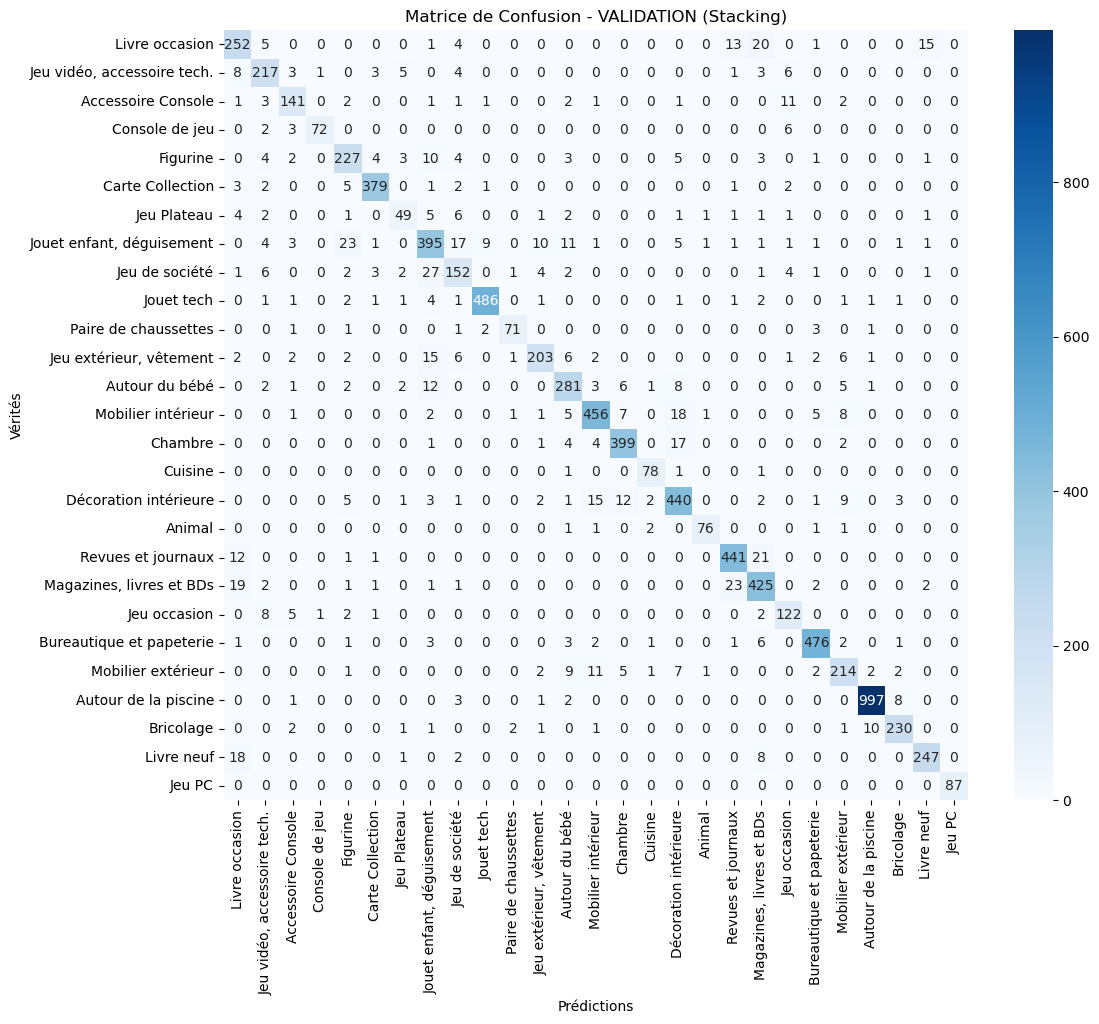


 Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_LR_model.joblib'


In [19]:
# Fusion verticale des probabilités texte et image pour TRAIN et VALIDATION
P_texte_train = np.vstack(df_merged_train["probabilities_text"])
P_image_train = np.vstack(df_merged_train["probabilities_image"])
P_texte_val = np.vstack(df_merged_val["probabilities_text"])
P_image_val = np.vstack(df_merged_val["probabilities_image"])

# Construction des features d'entrée pour le stacking par concaténation horizontale des probabilités
X_train_stack = np.hstack([P_texte_train, P_image_train])
X_val_stack = np.hstack([P_texte_val, P_image_val])

# Création du mapping entre les indices (0 à 26) et les labels réels Rakuten
sorted_labels = sorted(labelcat.keys())  
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}

# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Conversion des indices en labels réels dans les ensembles TRAIN et VALIDATION
df_merged_train["label_real"] = df_merged_train["label"].map(index_to_label)
df_merged_val["label_real"] = df_merged_val["label"].map(index_to_label)
y_train_real = df_merged_train["label_real"]
y_val_real = df_merged_val["label_real"]

# Définition des modèles de base (Level-0) pour le stacking
base_models = [
    ('camembert', LogisticRegression(solver="liblinear", max_iter=200)),        # Régression logistique appliquée à CamemBERT
    ('resnet', RandomForestClassifier(n_estimators=100))                        # Random Forest appliqué à ResNet
]

# Définition du méta-modèle (Level-1) pour l'étage final du stacking
meta_model = LogisticRegression(solver="liblinear", max_iter=200)  # Régression logistique en tant que classifieur final

# Construction du modèle de stacking (StackingClassifier de scikit-learn)
stacking_clf = StackingClassifier(
    estimators=base_models,            # Modèles de base
    final_estimator=meta_model,        # Méta-modèle
    stack_method='predict_proba',      # Utilisation des probabilités pour l'étage de fusion
    passthrough=True                   # Ajout des features originales aux entrées du méta-modèle
)

# Entraînement du modèle de stacking sur les features combinées
print("\n Entraînement du modèle StackingClassifier...")
stacking_clf.fit(X_train_stack, y_train_real)

# Génération des prédictions pour TRAIN et VALIDATION
y_pred_train_stack = stacking_clf.predict(X_train_stack)
y_pred_val_stack = stacking_clf.predict(X_val_stack)

# Calcul des scores F1 pondérés pour TRAIN et VALIDATION
train_f1_stack = f1_score(y_train_real, y_pred_train_stack, average="weighted")
val_f1_stack = f1_score(y_val_real, y_pred_val_stack, average="weighted")

# Affichage des scores F1 pondérés
print(f"\n Résultats avec le modèle StackingClassifier")
print(f"  - Weighted F1-score Train : {train_f1_stack:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1_stack:.4f}")

# Rapport de classification sur l'ensemble d'entraînement
print("\n Rapport de classification - TRAIN (Stacking) :")
print(classification_report(
    y_train_real,
    y_pred_train_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification sur l'ensemble de validation
print("\n Rapport de classification - VALIDATION (Stacking) :")
print(classification_report(
    y_val_real,
    y_pred_val_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage de la matrice de confusion sous forme de carte thermique"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage graphique de la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(y_val_real, y_pred_val_stack, sorted_labels, "Matrice de Confusion - VALIDATION (Stacking)")

# Création du dossier s'il n'existe pas
save_path = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_path, exist_ok=True)

# Sauvegarde du modèle de stacking
dump(stacking_clf, os.path.join(save_path, "stacking_LR_model.joblib"))
print("\n Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_LR_model.joblib'")

### Final estimator : SVC


 Entraînement du modèle StackingClassifier avec SVM en méta-modèle...

 Résultats finaux avec Stacking (SVM)
  - Weighted F1-score Train : 0.9665
  - Weighted F1-score Val   : 0.8993

 Rapport de classification - TRAIN (Stacking avec SVM) :
                             precision    recall  f1-score   support

             Livre occasion       0.95      0.94      0.95      2491
Jeu vidéo, accessoire tech.       0.97      0.97      0.97      1989
         Accessoire Console       0.94      0.98      0.96      1317
             Console de jeu       1.00      0.99      1.00       654
                   Figurine       0.91      0.93      0.92      2137
           Carte Collection       0.99      1.00      0.99      3161
                Jeu Plateau       0.89      0.86      0.88       611
  Jouet enfant, déguisement       0.92      0.90      0.91      3887
             Jeu de société       0.87      0.88      0.88      1636
                 Jouet tech       0.99      0.99      0.99      401

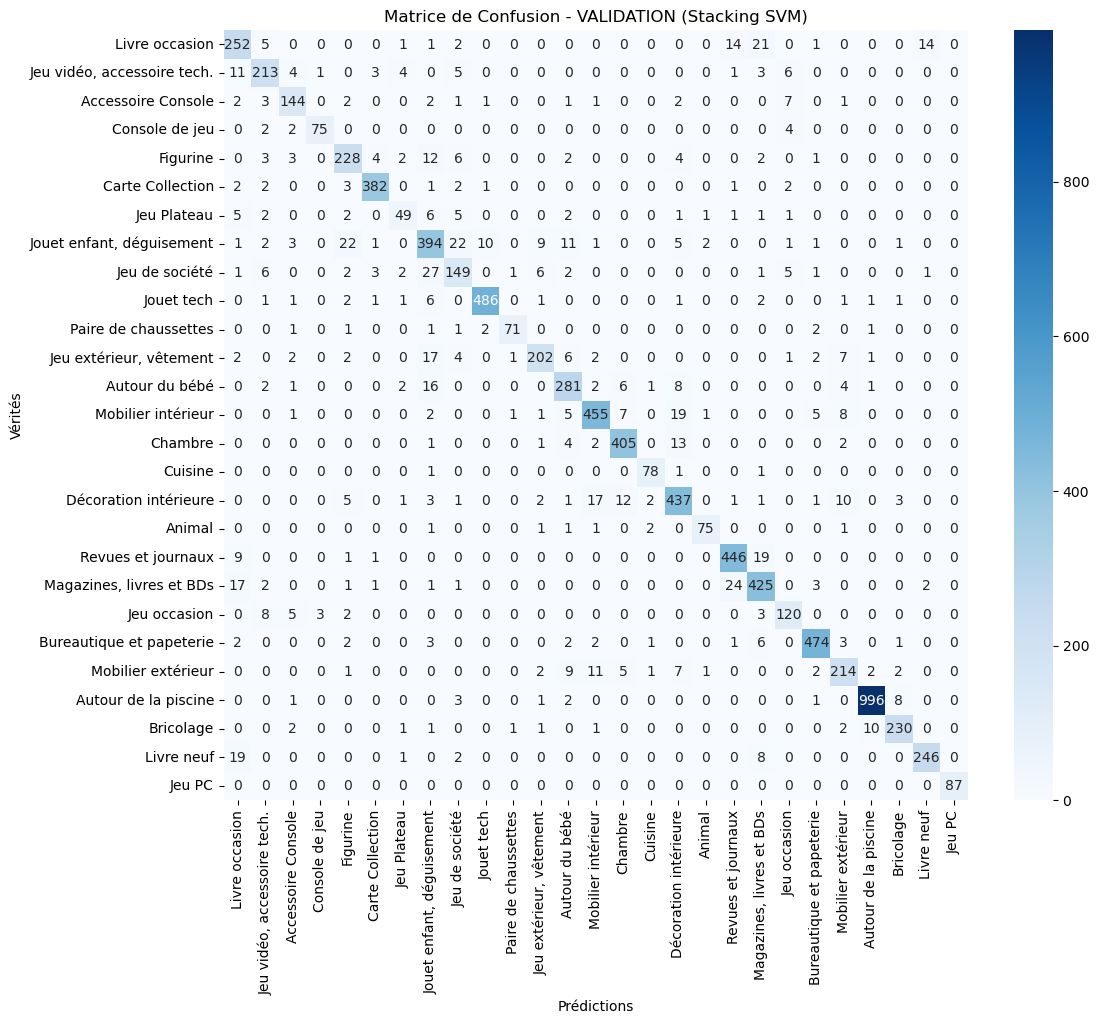


 Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_SVC_model.joblib'


In [20]:
# Construction des matrices de probabilités pour les modèles texte et image
P_texte_train = np.vstack(df_merged_train["probabilities_text"])
P_image_train = np.vstack(df_merged_train["probabilities_image"])
P_texte_val = np.vstack(df_merged_val["probabilities_text"])
P_image_val = np.vstack(df_merged_val["probabilities_image"])

# Fusion horizontale des probabilités pour créer les features d'entrée du modèle de stacking
X_train_stack = np.hstack([P_texte_train, P_image_train])
X_val_stack = np.hstack([P_texte_val, P_image_val])

# Création du dictionnaire de correspondance entre indices et labels réels Rakuten
sorted_labels = sorted(labelcat.keys())  
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}  

# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Conversion des indices en labels réels dans les jeux d'entraînement et de validation
df_merged_train["label_real"] = df_merged_train["label"].map(index_to_label)
df_merged_val["label_real"] = df_merged_val["label"].map(index_to_label)
y_train_real = df_merged_train["label_real"]
y_val_real = df_merged_val["label_real"]

# Définition des modèles de base (Level-0) pour le StackingClassifier
base_models = [
    ('camembert', SVC(kernel="linear", probability=True)),         # SVM linéaire pour les probabilités issues de CamemBERT
    ('resnet', RandomForestClassifier(n_estimators=100))           # Random Forest pour les probabilités issues de ResNet
]

# Définition du méta-modèle (Level-1) : SVM linéaire avec probabilité activée
meta_model = SVC(kernel="linear", probability=True)

# Création du StackingClassifier en mode soft avec passage des features originales
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=True
)

# Entraînement du modèle de stacking
print("\n Entraînement du modèle StackingClassifier avec SVM en méta-modèle...")
stacking_clf.fit(X_train_stack, y_train_real)

# Génération des prédictions sur les ensembles d'entraînement et de validation
y_pred_train_stack = stacking_clf.predict(X_train_stack)
y_pred_val_stack = stacking_clf.predict(X_val_stack)

# Calcul des scores F1 pondérés pour les deux ensembles
train_f1 = f1_score(y_train_real, y_pred_train_stack, average="weighted")
val_f1 = f1_score(y_val_real, y_pred_val_stack, average="weighted")

# Affichage des scores F1
print(f"\n Résultats finaux avec Stacking (SVM)")
print(f"  - Weighted F1-score Train : {train_f1:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1:.4f}")

# Rapport de classification sur l'ensemble d'entraînement
print("\n Rapport de classification - TRAIN (Stacking avec SVM) :")
print(classification_report(
    y_train_real,
    y_pred_train_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification sur l'ensemble de validation
print("\n Rapport de classification - VALIDATION (Stacking avec SVM) :")
print(classification_report(
    y_val_real,
    y_pred_val_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion (heatmap)
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage graphique de la matrice de confusion"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage de la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(y_val_real, y_pred_val_stack, sorted_labels, "Matrice de Confusion - VALIDATION (Stacking SVM)")


# Création du dossier s'il n'existe pas
save_path = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_path, exist_ok=True)

# Sauvegarde du modèle de stacking
dump(stacking_clf, os.path.join(save_path, "stacking_SVC_model.joblib"))
print("\n Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_SVC_model.joblib'")

### Final estimator : XGBoost


 Entraînement du modèle StackingClassifier avec XGBoost comme méta-modèle...

 Résultats finaux avec Stacking (XGBoost)
  - Weighted F1-score Train : 0.9784
  - Weighted F1-score Val   : 0.9011

 Rapport de classification - TRAIN (Stacking avec XGBoost) :
                             precision    recall  f1-score   support

             Livre occasion       0.97      0.96      0.96      2491
Jeu vidéo, accessoire tech.       0.97      0.98      0.97      1989
         Accessoire Console       0.96      0.98      0.97      1317
             Console de jeu       1.00      0.99      0.99       654
                   Figurine       0.94      0.97      0.96      2137
           Carte Collection       0.99      1.00      1.00      3161
                Jeu Plateau       0.94      0.91      0.92       611
  Jouet enfant, déguisement       0.96      0.94      0.95      3887
             Jeu de société       0.95      0.93      0.94      1636
                 Jouet tech       1.00      1.00    

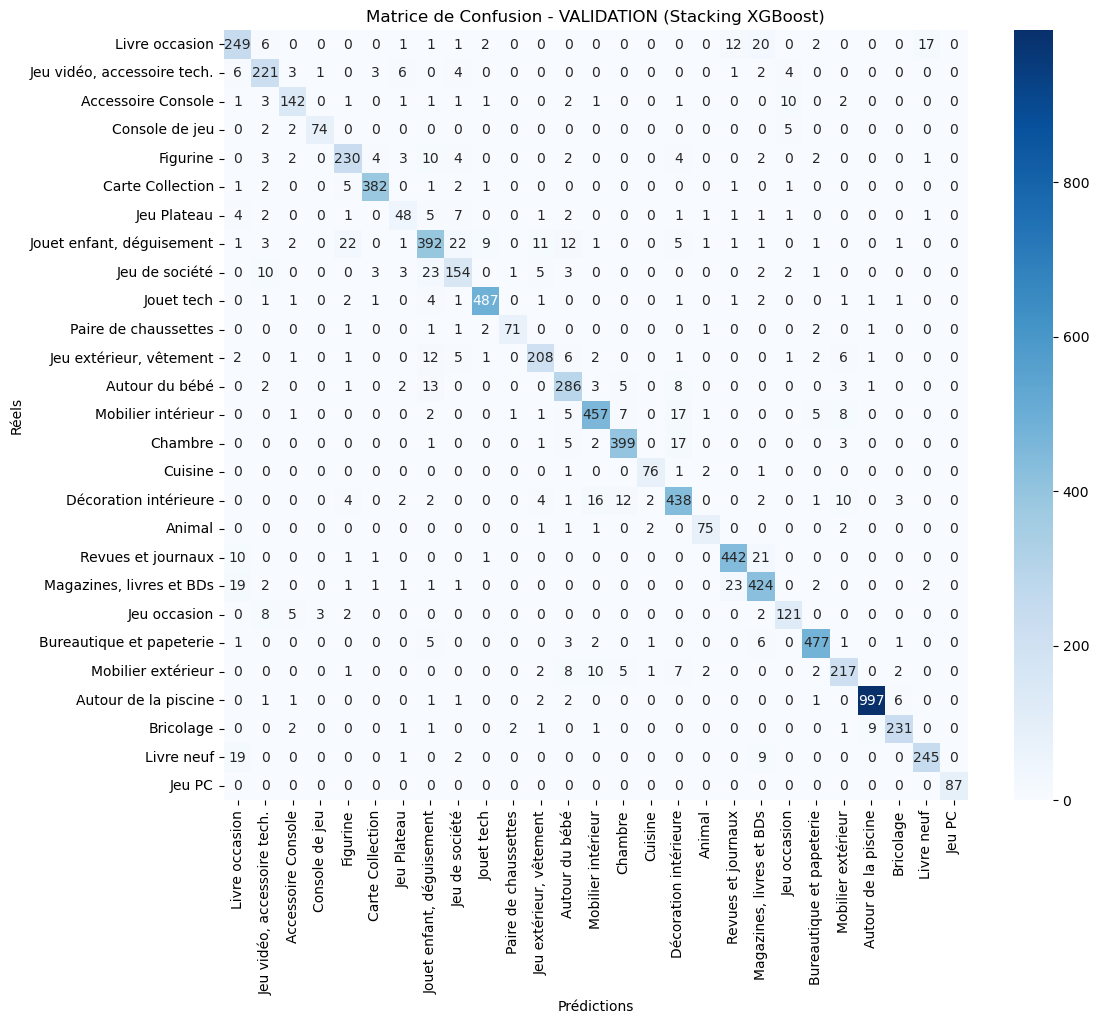


 Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_xgb_model.joblib'


In [18]:
# Construction des matrices de probabilités pour chaque modèle (Texte et Image)
P_texte_train = np.vstack(df_merged_train["probabilities_text"])
P_image_train = np.vstack(df_merged_train["probabilities_image"])
P_texte_val = np.vstack(df_merged_val["probabilities_text"])
P_image_val = np.vstack(df_merged_val["probabilities_image"])

# Fusion horizontale des probabilités comme features d'entrée du stacking
X_train_stack = np.hstack([P_texte_train, P_image_train])
X_val_stack = np.hstack([P_texte_val, P_image_val])

# Création du mapping entre les indices (0 à 26) et les labels réels Rakuten
sorted_labels = sorted(labelcat.keys())
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}

# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Conversion des indices de classes en labels réels dans les DataFrames
df_merged_train["label_real"] = df_merged_train["label"].map(index_to_label)
df_merged_val["label_real"] = df_merged_val["label"].map(index_to_label)
y_train_real = df_merged_train["label_real"]
y_val_real = df_merged_val["label_real"]

# Définition des modèles de base (Level-0) pour le stacking
base_models = [
    ('camembert', SVC(kernel="linear", probability=True)),                  # SVM linéaire basé sur les probabilités CamemBERT
    ('resnet', RandomForestClassifier(n_estimators=100))                   # Random Forest basé sur les probabilités ResNet
]

# Définition du méta-modèle (Level-1) basé sur XGBoost
meta_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(sorted_labels),
    learning_rate=0.01,
    n_estimators=150,
    max_depth=3,
    subsample=0.6,
    colsample_bytree=0.7,
    reg_lambda=1.0,   # Régularisation L2
    reg_alpha=0.5     # Régularisation L1
)

# Création du StackingClassifier avec utilisation des probabilités en entrée
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=True  # Ajout des features originales à l'entrée du méta-modèle
)

# Entraînement du modèle de stacking
print("\n Entraînement du modèle StackingClassifier avec XGBoost comme méta-modèle...")
stacking_clf.fit(X_train_stack, y_train_real)

# Prédictions sur les ensembles d'entraînement et de validation
y_pred_train_stack = stacking_clf.predict(X_train_stack)
y_pred_val_stack = stacking_clf.predict(X_val_stack)

# Calcul des scores F1 pondérés
train_f1 = f1_score(y_train_real, y_pred_train_stack, average="weighted")
val_f1 = f1_score(y_val_real, y_pred_val_stack, average="weighted")

# Affichage des scores F1 pondérés
print(f"\n Résultats finaux avec Stacking (XGBoost)")
print(f"  - Weighted F1-score Train : {train_f1:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1:.4f}")

# Rapport de classification sur l'ensemble d'entraînement
print("\n Rapport de classification - TRAIN (Stacking avec XGBoost) :")
print(classification_report(
    y_train_real,
    y_pred_train_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification sur l'ensemble de validation
print("\n Rapport de classification - VALIDATION (Stacking avec XGBoost) :")
print(classification_report(
    y_val_real,
    y_pred_val_stack,
    target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage de la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(y_val_real, y_pred_val_stack, sorted_labels, "Matrice de Confusion - VALIDATION (Stacking XGBoost)")


# Création du dossier s'il n'existe pas
save_path = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_path, exist_ok=True)

# Sauvegarde du modèle de stacking
dump(stacking_clf, os.path.join(save_path, "stacking_xgb_model.joblib"))
print("\n Modèle Stacking sauvegardé dans './L_fusion/Sauvegarde modeles/stacking_xgb_model.joblib'")


# **Staking + voting soft** 

### Final estimator : Logistic Regression


 Entraînement du modèle StackingClassifier...

  - Weighted F1-score Train : 0.9562
  - Weighted F1-score Val   : 0.8986

  Rapport détaillé de classification sur l'ensemble d'entraînement :
                             precision    recall  f1-score   support

             Livre occasion       0.91      0.91      0.91      2491
Jeu vidéo, accessoire tech.       0.95      0.95      0.95      1989
         Accessoire Console       0.93      0.98      0.95      1317
             Console de jeu       0.98      0.96      0.97       654
                   Figurine       0.92      0.93      0.92      2137
           Carte Collection       0.99      0.99      0.99      3161
                Jeu Plateau       0.86      0.82      0.84       611
  Jouet enfant, déguisement       0.89      0.90      0.89      3887
             Jeu de société       0.87      0.83      0.85      1636
                 Jouet tech       0.99      0.99      0.99      4010
       Paire de chaussettes       0.99      0.98

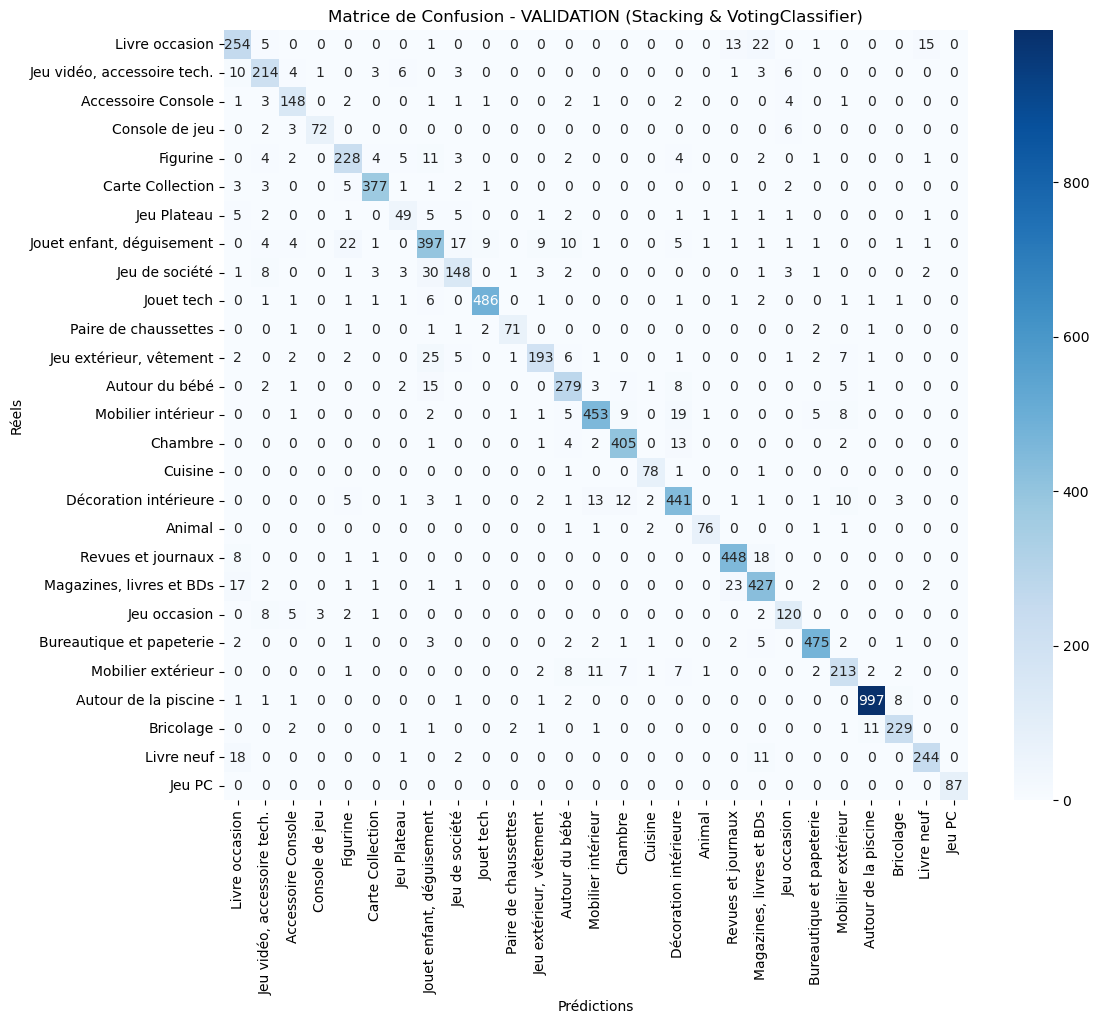


 Modèle de stacking&voting sauvegardé dans './L_fusion/Sauvegarde modeles/stacking&voting_LR_model.joblib'


In [16]:
# Fonction de conversion des probabilités sous forme de chaînes vers des tableaux numpy
def safe_convert_probabilities(column):
    return column.apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

# Application de la conversion sur les colonnes de probabilités texte et image (pour TRAIN et VALIDATION)
for df in [df_merged_train, df_merged_val]:
    df[["probabilities_text", "probabilities_image"]] = df[
        ["probabilities_text", "probabilities_image"]
    ].apply(safe_convert_probabilities)
    
# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Extraction des matrices de probabilités (Texte et Image) pour TRAIN et VALIDATION
P_texte_train, P_image_train = np.vstack(df_merged_train["probabilities_text"]), np.vstack(df_merged_train["probabilities_image"])
P_texte_val, P_image_val = np.vstack(df_merged_val["probabilities_text"]), np.vstack(df_merged_val["probabilities_image"])

# Extraction des labels bruts à partir des DataFrames fusionnés
y_train = df_merged_train["label"].values  
y_val = df_merged_val["label"].values  

# Création du dictionnaire de correspondance entre indices et labels réels
sorted_labels = sorted(labelcat.keys())  
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}  

# Construction du VotingClassifier en mode Soft Voting avec pondération des modèles
voting_clf = VotingClassifier(
    estimators=[
        ('camembert', LogisticRegression(max_iter=200)),  # Régression logistique sur CamemBERT
        ('resnet', LogisticRegression(max_iter=200))      # Régression logistique sur ResNet
    ],
    voting='soft',
    weights=[0.6, 0.4]
)

# Création de features factices pour respecter l'API de scikit-learn
X_train_fake = np.zeros((P_texte_train.shape[0], 1))  
X_val_fake = np.zeros((P_texte_val.shape[0], 1))  

# Entraînement du VotingClassifier sur les données factices et les vrais labels
voting_clf.fit(X_train_fake, y_train)

# Génération des prédictions à partir du VotingClassifier
y_pred_train_voting = voting_clf.predict(X_train_fake)
y_pred_val_voting = voting_clf.predict(X_val_fake)

# Extraction des probabilités prédites par le VotingClassifier
P_train_voting = voting_clf.predict_proba(X_train_fake)
P_val_voting = voting_clf.predict_proba(X_val_fake)

# Construction des features de stacking par concaténation des probabilités
X_train_stack = np.hstack([P_train_voting, P_texte_train, P_image_train])
X_val_stack = np.hstack([P_val_voting, P_texte_val, P_image_val])

# Définition du méta-modèle pour l'étape finale du stacking
meta_model = LogisticRegression(max_iter=200)

# Entraînement du méta-modèle sur les features combinées
print("\n Entraînement du modèle StackingClassifier...\n")
meta_model.fit(X_train_stack, y_train)

# Génération des prédictions finales avec le modèle de stacking
y_pred_train_stack = meta_model.predict(X_train_stack)
y_pred_val_stack = meta_model.predict(X_val_stack)

# Conversion des prédictions et des vérités en labels réels Rakuten
y_pred_train_real = np.array([index_to_label[idx] for idx in y_pred_train_stack])
y_pred_val_real = np.array([index_to_label[idx] for idx in y_pred_val_stack])
y_train_real = np.array([index_to_label[idx] for idx in y_train])
y_val_real = np.array([index_to_label[idx] for idx in y_val])

# Évaluation des performances via le F1-score pondéré
train_f1 = f1_score(y_train_real, y_pred_train_real, average="weighted")
val_f1 = f1_score(y_val_real, y_pred_val_real, average="weighted")

# Affichage des scores F1 pondérés pour TRAIN et VALIDATION
print(f"  - Weighted F1-score Train : {train_f1:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1:.4f}")

# Rapport de classification sur l'ensemble d'entraînement
print("\n  Rapport détaillé de classification sur l'ensemble d'entraînement :")
print(classification_report(
    y_train_real, y_pred_train_real, target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification sur l'ensemble de validation
print("\n Rapport détaillé de classification sur l'ensemble de validation :")
print(classification_report(
    y_val_real, y_pred_val_real, target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage de la matrice de confusion avec les noms de catégories"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Réels")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage de la matrice de confusion pour l'ensemble de validation
plot_confusion_matrix(y_val_real, y_pred_val_real, sorted_labels, "Matrice de Confusion - VALIDATION (Stacking & VotingClassifier)")

# Dossier de sauvegarde
save_path = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_path, exist_ok=True)

# Sauvegarde du méta-modèle (LogisticRegression)
dump(meta_model, os.path.join(save_path, "stacking&voting_LR_model.joblib"))

print("\n Modèle de stacking&voting sauvegardé dans './L_fusion/Sauvegarde modeles/stacking&voting_LR_model.joblib'")

### Final estimator : SVM


 Entraînement du modèle StackingClassifier...


 Résultats finaux :
  - Weighted F1-score Train : 0.9562
  - Weighted F1-score Val   : 0.8963

 Rapport détaillé de classification sur l'ensemble d'entraînement :
                             precision    recall  f1-score   support

             Livre occasion       0.91      0.91      0.91      2491
Jeu vidéo, accessoire tech.       0.95      0.95      0.95      1989
         Accessoire Console       0.92      0.98      0.95      1317
             Console de jeu       0.98      0.96      0.97       654
                   Figurine       0.91      0.93      0.92      2137
           Carte Collection       0.99      0.99      0.99      3161
                Jeu Plateau       0.86      0.83      0.85       611
  Jouet enfant, déguisement       0.90      0.89      0.89      3887
             Jeu de société       0.85      0.85      0.85      1636
                 Jouet tech       0.99      0.99      0.99      4010
       Paire de chaussettes 

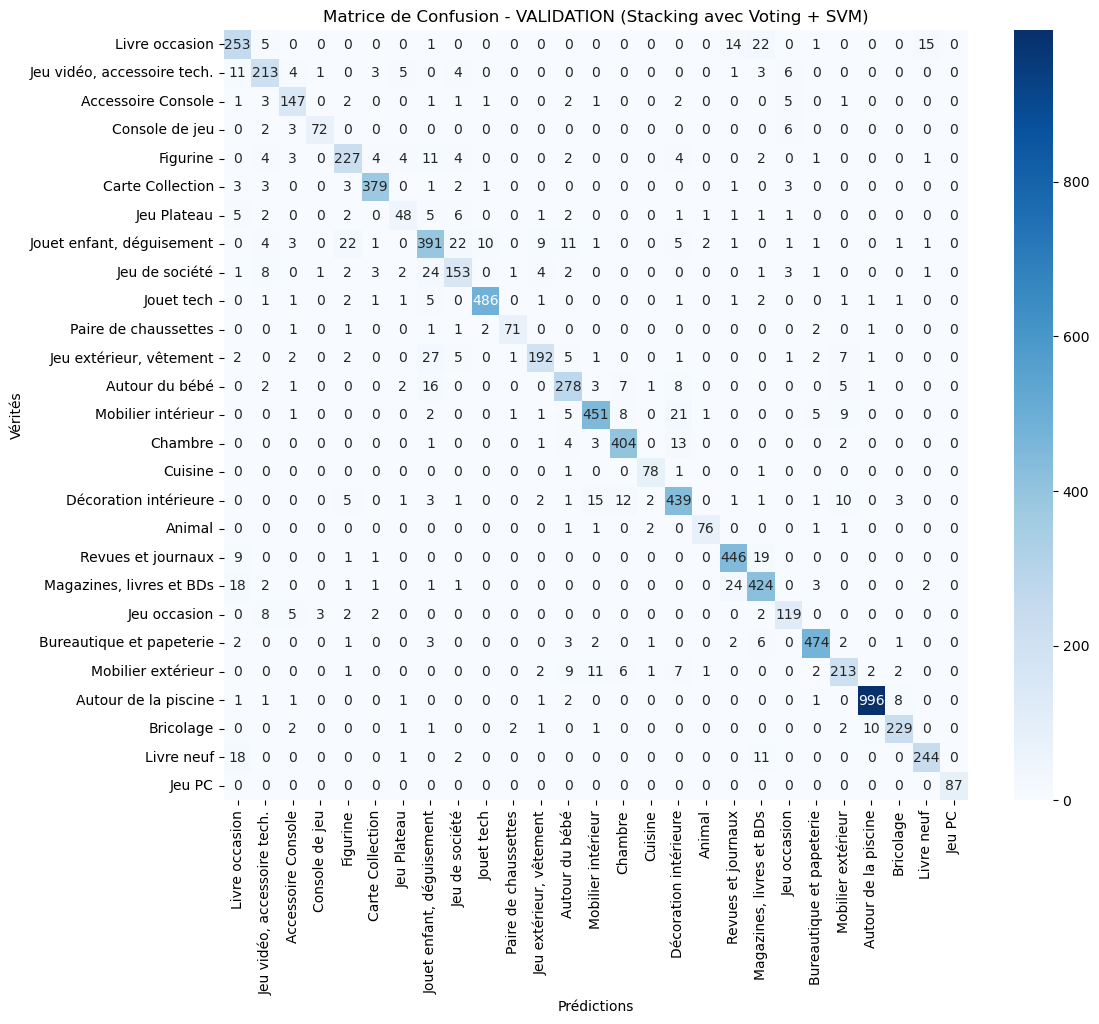


 Modèle de stacking&voting sauvegardé dans './L_fusion/Sauvegarde modeles/stacking&voting_LR_model.joblib'


In [4]:
# Fonction de conversion des probabilités sous forme de chaînes vers des tableaux numpy
def safe_convert_probabilities(column):
    return column.apply(lambda x: np.array(eval(x)) if isinstance(x, str) else np.array(x))

# Application de la conversion sur les colonnes de probabilités texte et image (pour TRAIN et VALIDATION)
for df in [df_merged_train, df_merged_val]:
    df[["probabilities_text", "probabilities_image"]] = df[
        ["probabilities_text", "probabilities_image"]
    ].apply(safe_convert_probabilities)
    
# Application de la conversion sur les colonnes de probabilités dans les ensembles TRAIN et VALIDATION
df_merged_train[["probabilities_text", "probabilities_image"]] = df_merged_train[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)
df_merged_val[["probabilities_text", "probabilities_image"]] = df_merged_val[["probabilities_text", "probabilities_image"]].apply(safe_convert_probabilities)

# Extraction des matrices de probabilités (Texte et Image) pour TRAIN et VALIDATION
P_texte_train, P_image_train = np.vstack(df_merged_train["probabilities_text"]), np.vstack(df_merged_train["probabilities_image"])
P_texte_val, P_image_val = np.vstack(df_merged_val["probabilities_text"]), np.vstack(df_merged_val["probabilities_image"])

# Extraction des labels bruts depuis les DataFrames
y_train = df_merged_train["label"].values  
y_val = df_merged_val["label"].values  

# Création du mapping entre indices (0 à 26) et labels réels Rakuten
sorted_labels = sorted(labelcat.keys())  
index_to_label = {i: sorted_labels[i] for i in range(len(sorted_labels))}  

# Construction du VotingClassifier avec pondération (Soft Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('camembert', LogisticRegression(max_iter=200)),  # Régression logistique sur les sorties CamemBERT
        ('resnet', LogisticRegression(max_iter=200))      # Régression logistique sur les sorties ResNet
    ],
    voting='soft',
    weights=[0.6, 0.4]
)

# Création des features factices pour satisfaire l'interface du VotingClassifier
X_train_fake = np.zeros((P_texte_train.shape[0], 1))  
X_val_fake = np.zeros((P_texte_val.shape[0], 1))  

# Entraînement du VotingClassifier sur les labels et les features factices
voting_clf.fit(X_train_fake, y_train)

# Prédictions effectuées à l'aide du VotingClassifier
y_pred_train_voting = voting_clf.predict(X_train_fake)
y_pred_val_voting = voting_clf.predict(X_val_fake)

# Extraction des probabilités prédictives pour stacking
P_train_voting = voting_clf.predict_proba(X_train_fake)
P_val_voting = voting_clf.predict_proba(X_val_fake)

# Construction des features finales de stacking par concaténation des probabilités
X_train_stack = np.hstack([P_train_voting, P_texte_train, P_image_train])
X_val_stack = np.hstack([P_val_voting, P_texte_val, P_image_val])

# Définition du méta-modèle de stacking : SVM linéaire avec activation des probabilités
meta_model = SVC(kernel="linear", probability=True)

# Entraînement du méta-modèle sur les features empilées
print("\n Entraînement du modèle StackingClassifier...\n")
meta_model.fit(X_train_stack, y_train)

# Génération des prédictions finales à partir du modèle empilé
y_pred_train_stack = meta_model.predict(X_train_stack)
y_pred_val_stack = meta_model.predict(X_val_stack)

# Conversion des prédictions et vérités en labels réels Rakuten
y_pred_train_real = np.array([index_to_label[idx] for idx in y_pred_train_stack])
y_pred_val_real = np.array([index_to_label[idx] for idx in y_pred_val_stack])
y_train_real = np.array([index_to_label[idx] for idx in y_train])
y_val_real = np.array([index_to_label[idx] for idx in y_val])

# Calcul des F1-scores pondérés pour les ensembles d'entraînement et de validation
train_f1 = f1_score(y_train_real, y_pred_train_real, average="weighted")
val_f1 = f1_score(y_val_real, y_pred_val_real, average="weighted")

# Affichage des scores F1 pondérés
print(f"\n Résultats finaux :")
print(f"  - Weighted F1-score Train : {train_f1:.4f}")
print(f"  - Weighted F1-score Val   : {val_f1:.4f}")

# Rapport de classification sur l'ensemble d'entraînement
print("\n Rapport détaillé de classification sur l'ensemble d'entraînement :")
print(classification_report(
    y_train_real, y_pred_train_real, target_names=[labelcat[l] for l in sorted_labels]
))

# Rapport de classification sur l'ensemble de validation
print("\n Rapport détaillé de classification sur l'ensemble de validation :")
print(classification_report(
    y_val_real, y_pred_val_real, target_names=[labelcat[l] for l in sorted_labels]
))

# Définition de la fonction d'affichage de la matrice de confusion sous forme de heatmap
def plot_confusion_matrix(y_true, y_pred, labels, title):
    """Affichage visuel de la matrice de confusion avec noms des catégories"""
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    label_names = [labelcat[l] for l in labels]

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Prédictions")
    plt.ylabel("Vérités")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Affichage de la matrice de confusion sur l'ensemble de validation
plot_confusion_matrix(y_val_real, y_pred_val_real, sorted_labels, "Matrice de Confusion - VALIDATION (Stacking avec Voting + SVM)")

# Dossier de sauvegarde
save_path = "./L_fusion/Sauvegarde modeles"
os.makedirs(save_path, exist_ok=True)

# Sauvegarde du méta-modèle (LogisticRegression)
dump(meta_model, os.path.join(save_path, "stacking&voting_LR_model.joblib"))

print("\n Modèle de stacking&voting sauvegardé dans './L_fusion/Sauvegarde modeles/stacking&voting_LR_model.joblib'")